In [33]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#PATH dove andare a leggere e a scrivere
PATH_TO_WRITE_ETL = "./dataset_modificato/"
PATH_FROM_READ_ETL = "./dataset_originale/"
PATH_FROM_READ_ANALYSIS = "./dataset_modificato/" 

In [10]:
# PRIMA FASE DI ETL: Aggiunta manuale delle presenze dei giocatori e integrazione con il dataset che abbiamo a disposizione

test = pd.read_csv("./incremental_modify.csv",encoding = "ISO-8859-1",delimiter=";",)
test = test.drop(columns=["family_name","given_name"])
df = pd.read_csv(PATH_FROM_READ_ETL + "players.csv")

df_players = df[["player_id","family_name","given_name"]]
final = test.merge(df_players,on="player_id",how="left")
final = final[["key_id","tournament_id","tournament_name","match_id","match_name","match_date","stage_name","group_name","team_id","team_name","team_code","home_team","away_team","player_id","family_name","given_name","shirt_number","position_name","position_code","starter","substitute","captain","red_card","yellow_card"]]
#test["shirt_number"] = test["shirt_number"].astype(str)

df_players
#cambio del formato della data
final["match_date"] = pd.to_datetime(final["match_date"],dayfirst=True)
final["match_date"] = final["match_date"].dt.strftime('%Y-%m-%d')

final.to_csv("./player_appearances_da_integrare.csv",index=False)

# verifica che non ci siano doppioni in una stessa partita
df = pd.read_csv("./player_appearances_da_integrare.csv")
print(len(df))
print(len(df[["match_id",'player_id']].drop_duplicates()))

# unione tra il file player-apperance e player_appearances_da_integrare
df_player_appearances = pd.read_csv(PATH_FROM_READ_ETL + "player_appearances.csv")

df_concat_pa = pd.concat([df_player_appearances,df],ignore_index=True,sort=False)
df_concat_pa['red_card'] = df_concat_pa['red_card'].fillna(0).astype(int)
df_concat_pa['yellow_card'] = df_concat_pa['yellow_card'].fillna(0).astype(int)
df_concat_pa['shirt_number'] = pd.to_numeric(df_concat_pa['shirt_number'],errors='coerce').astype('Int64')


# aggiunta dei cartellini gialli e rossi
# non abbiamo il dato del minutaggio del cartellino, abbiamo deciso di assegnare la media dei minutaggi dei cartellini gialli e rossi
df_bookings = pd.read_csv(PATH_FROM_READ_ETL + "bookings.csv")
df_bookings
df_player_appearances = pd.read_csv("./player_appearances_da_integrare.csv")
df_bookings_yellow = df_bookings[df_bookings["yellow_card"] == 1]
df_bookings_yellow
mean_y = df_bookings_yellow['minute_regulation'].mean(numeric_only=True)
mean_int_y = int(mean_y)
df_pa_yellow = df_player_appearances[df_player_appearances.yellow_card == 1].reset_index()
columns_bookings = "key_id,booking_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name,given_name,shirt_number,minute_label,minute_regulation,minute_stoppage,match_period,yellow_card,red_card,second_yellow_card,sending_off"
columns_bookings_second_part = "home_team,away_team,player_id,family_name,given_name,shirt_number,minute_label,minute_regulation,minute_stoppage,match_period,yellow_card,red_card,second_yellow_card,sending_off"
columns_player_appearances = "key_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name,given_name,shirt_number,position_name,position_code,starter,substitute,captain,red_card,yellow_card"

k = 2467
data = []
for j in range(len(df_pa_yellow)):

    data.append([k, "B-" + str(k),df_pa_yellow.loc[j]['tournament_id'], df_pa_yellow.loc[j]['tournament_name'], df_pa_yellow.loc[j]['match_id'],
                 df_pa_yellow.loc[j]['match_name'], df_pa_yellow.loc[j]['match_date'], df_pa_yellow.loc[j]['stage_name'],
                 df_pa_yellow.loc[j]['group_name'], df_pa_yellow.loc[j]['team_id'], df_pa_yellow.loc[j]['team_name'],
                 df_pa_yellow.loc[j]['team_code'], df_pa_yellow.loc[j]['home_team'], df_pa_yellow.loc[j]['away_team'],
                 df_pa_yellow.loc[j]['player_id'], df_pa_yellow.loc[j]['family_name'], df_pa_yellow.loc[j]['given_name'], 
                 df_pa_yellow.loc[j]['shirt_number'], str(mean_int_y)+"'",mean_int_y, 0, "second half",1,0,0,0
                 
                ])
    k+=1
df_yellow_cards = pd.DataFrame(data, columns=df_bookings_yellow.columns.to_list())


df_bookings_red = df_bookings[df_bookings["red_card"] == 1]
mean_r = df_bookings_red['minute_regulation'].mean(numeric_only=True)
mean_int_r = int(mean_r)
df_pa_red = df_player_appearances[df_player_appearances.red_card == 1].reset_index()

data = []
for j in range(len(df_pa_red)):

    data.append([k, "B-" + str(k),df_pa_red.loc[j]['tournament_id'], df_pa_red.loc[j]['tournament_name'], df_pa_red.loc[j]['match_id'],
                 df_pa_red.loc[j]['match_name'], df_pa_red.loc[j]['match_date'], df_pa_red.loc[j]['stage_name'],
                 df_pa_red.loc[j]['group_name'], df_pa_red.loc[j]['team_id'], df_pa_red.loc[j]['team_name'],
                 df_pa_red.loc[j]['team_code'], df_pa_red.loc[j]['home_team'], df_pa_red.loc[j]['away_team'],
                 df_pa_red.loc[j]['player_id'], df_pa_red.loc[j]['family_name'], df_pa_red.loc[j]['given_name'], 
                 df_pa_red.loc[j]['shirt_number'], str(mean_int_r)+"'",mean_int_r, 0, "second half",0,1,0,1
                 
                ])
    k+=1
df_red_cards = pd.DataFrame(data, columns=df_bookings_red.columns.to_list())

df_concat_bookings = pd.concat([df_bookings,df_yellow_cards,df_red_cards],ignore_index=True,sort=False)
df_concat_bookings['shirt_number'] = pd.to_numeric(df_concat_bookings['shirt_number'],errors='coerce').astype('Int64')
df_concat_bookings.to_csv(PATH_TO_WRITE_ETL +"bookings.csv",index=False)

#eliminazione delle colonne "yellow_card" e "red_card" da "player_appearances"
df_concat_pa = df_concat_pa.drop(columns=["yellow_card","red_card"])
df_concat_pa.to_csv(PATH_TO_WRITE_ETL +"player_appearances.csv",index=False)

4400
4400


In [12]:
#INIZIO RAGGRUPPAMENTO DATI PER INIZIARE L'ANALISI SUI GIOCATORI
df_tournaments = pd.read_csv(PATH_FROM_READ_ANALYSIS + "tournaments.csv")
df_players = pd.read_csv(PATH_FROM_READ_ANALYSIS + "players.csv")
df_goals = pd.read_csv(PATH_FROM_READ_ANALYSIS + "goals.csv")
df_player_appearances = pd.read_csv(PATH_FROM_READ_ANALYSIS + "player_appearances.csv")
df_bookings = pd.read_csv(PATH_FROM_READ_ANALYSIS + "bookings.csv")
df_substitution = pd.read_csv(PATH_FROM_READ_ANALYSIS + "substitutions.csv")
df_matches = pd.read_csv(PATH_FROM_READ_ANALYSIS + "matches.csv")
df_squads = pd.read_csv(PATH_FROM_READ_ANALYSIS + "squads.csv")
df_tournament_standings = pd.read_csv(PATH_FROM_READ_ANALYSIS + "tournament_standings.csv")


#numero di mondiali a cui hanno partecipato i giocatori

n_tournaments_by_players = df_squads.groupby(["player_id"]).size()\
             .reset_index(name="n_tournaments")

#numero di mondiali giocati (con almeno una presenza) a cui hanno partecipato i giocatori

n_tournaments_played_by_players = df_player_appearances[['player_id','tournament_id']].drop_duplicates()
n_tournaments_played_by_players = n_tournaments_played_by_players.groupby(["player_id"]).size()\
                                                                 .reset_index(name="n_tournaments_played")

#calcolo finali giocate dai calciatori

players_play_final = df_player_appearances[df_player_appearances['stage_name'] == 'final']
players_play_final = players_play_final.groupby(["player_id"])['player_id'].agg('count').reset_index(name="total_final_match_played").sort_values(by="total_final_match_played",ascending=False)

#calcolo mondiali vinti dai calciatori

players_winning_WC = df_tournament_standings[df_tournament_standings['position'] == 1]\
                                            [['team_id','tournament_id']]

players_winning_WC = players_winning_WC.merge(df_squads,how="left",on=["team_id","tournament_id"])
players_winning_WC = players_winning_WC.groupby(["player_id"]).size()\
                                       .reset_index(name="n_wc_wins")\
                                       .sort_values(by="n_wc_wins",ascending=False)


#conteggio dei goal di ogni giocatore
goals = df_goals[df_goals["own_goal"] != 1]
goals = goals.groupby(["player_id"])['player_id'].agg('count').reset_index(name="total_goals").sort_values(by="total_goals",ascending=False)

#conteggio degli autogoal di ogni giocatore
own_goals = df_goals[df_goals["own_goal"] == 1]
own_goals = own_goals.groupby(["player_id"])['player_id'].agg('count').reset_index(name="total_own_goals")

#conteggio dei penalty di ogni giocatore
penalty = df_goals[df_goals["penalty"] == 1]
penalty = penalty.groupby(["player_id"])['player_id'].agg('count').reset_index(name="total_penalty_scored")

#aggiunta numero minuti match
df_matches["n_minutes_match"] = 90
df_matches.loc[df_matches["extra_time"]==1, "n_minutes_match"] = 120

#aggiunta numero minuti match - periodo GOLDEN GOAL (1993-2004)
last_goal_in_golden_goal_years = df_goals[(df_goals.tournament_id == "WC-1998") | (df_goals.tournament_id == "WC-2002")]\
                                    .groupby(["match_id"])[['minute_regulation']]\
                                    .agg('max')\
                                    .reset_index()

last_goal_in_golden_goal_years=last_goal_in_golden_goal_years[last_goal_in_golden_goal_years.minute_regulation >90]

for index,row in last_goal_in_golden_goal_years.iterrows():
    df_matches.loc[df_matches["match_id"]==row.match_id, "n_minutes_match"] = row.minute_regulation

#aggiunta numero minuti giocati giocatori e ammonizioni o espulsioni
player_booked_in_match = df_bookings.groupby(["match_id","player_id"])[['yellow_card','second_yellow_card','red_card']].agg('sum').reset_index()
print("sum",len(player_booked_in_match))
max_minutes_in_match = df_bookings.groupby(["match_id","player_id"])['minute_regulation'].agg('max').reset_index()
print("max",len(max_minutes_in_match))
player_booked_in_match = player_booked_in_match.merge(max_minutes_in_match,on=["match_id","player_id"],how="left")
print("merge",len(player_booked_in_match))

df_player_appearances["n_minutes_played"] = 0
print("a 0",len(df_player_appearances))

#calcolo del numero di partite giocate
match_played = df_player_appearances.groupby(["player_id"])["match_id"].agg('count').reset_index(name="total_games_played")

df_player_appearances = df_player_appearances[['match_id','player_id','substitute','n_minutes_played']]
df_player_appearances = df_player_appearances.merge(df_matches[["match_id","n_minutes_match"]],on="match_id",how="left")
print("merge",len(df_player_appearances))
df_player_appearances = df_player_appearances.merge(player_booked_in_match,on=["match_id","player_id"],how="left")
print("merge2",len(df_player_appearances))
#se non è stato sostituito o non è stato espulso => ha giocato tutti i minuti
df_player_appearances.loc[df_player_appearances["substitute"]==0, "n_minutes_played"] = df_player_appearances["n_minutes_match"]
df_player_appearances.loc[df_player_appearances["red_card"]!=1, "n_minutes_played"] = df_player_appearances["n_minutes_match"]
df_player_appearances = df_player_appearances\
                        .rename(columns={"minute_regulation": "minute_booking"})

#merge con la tabella substitution => otteniamo giocatori sostituiti
df_substitution = df_substitution[["match_id","minute_regulation","player_id","going_off","coming_on"]]
df_substitution_groupby = df_substitution.groupby(["match_id","player_id"])['minute_regulation'].agg('max').reset_index()
df_substitution_groupby_MIN = df_substitution.groupby(["match_id","player_id"])['minute_regulation'].agg('min').reset_index()

print(len(df_substitution_groupby))
df_substitution = df_substitution_groupby.merge(df_substitution,on=["match_id","player_id",'minute_regulation'],how="left")
print("substitution",len(df_substitution_groupby))
df_substitution = df_substitution\
                        .rename(columns={"minute_regulation": "minute_substitution"})

df_player_appearances = df_player_appearances.merge(df_substitution,on=["match_id","player_id"],how="left")

print("substitutions",len(df_player_appearances))


print(df_player_appearances.columns)

# 0 - sostituzione dei valori nan con 0

df_player_appearances['n_minutes_played'] = df_player_appearances['n_minutes_played'].fillna(0).astype(int)
df_player_appearances['yellow_card'] = df_player_appearances['yellow_card'].fillna(0).astype(int)
df_player_appearances['second_yellow_card'] = df_player_appearances['second_yellow_card'].fillna(0).astype(int)
df_player_appearances['red_card'] = df_player_appearances['red_card'].fillna(0).astype(int)
df_player_appearances['minute_booking'] = df_player_appearances['minute_booking'].fillna(0).astype(int)
df_player_appearances['minute_substitution'] = df_player_appearances['minute_substitution'].fillna(0).astype(int)
df_player_appearances['going_off'] = df_player_appearances['going_off'].fillna(0).astype(int)
df_player_appearances['coming_on'] = df_player_appearances['coming_on'].fillna(0).astype(int)

# 1 - se è stato sostituito => minuto in cui è stato sostituito diventano i minuti giocati

df_player_appearances.loc[df_player_appearances["going_off"]==1, "n_minutes_played"] = df_player_appearances["minute_substitution"]

# 2 - se è entrato => durata partita - minuto in cui è entrato = minuti giocati

df_player_appearances.loc[df_player_appearances["coming_on"]==1, "n_minutes_played"] = df_player_appearances["n_minutes_match"] - df_player_appearances["minute_substitution"] + 1

# 2a - casi dei giocatori che sono entrati e che sono usciti nella stessa partita
df_substitution_groupby_MIN["difference"] = df_substitution_groupby["minute_regulation"] - df_substitution_groupby_MIN["minute_regulation"]
df_substitution_IN_OUT = df_substitution_groupby_MIN[df_substitution_groupby_MIN["difference"] > 0]

# 2b - quei giocaotori hanno effettivamente giocato il minutaggio contenuto in difference

df_player_appearances = df_player_appearances.merge(df_substitution_IN_OUT,on=["match_id","player_id"],how="left")
print("in-out",len(df_player_appearances))
df_player_appearances.loc[df_player_appearances["difference"] > 0, "n_minutes_played"] = df_player_appearances["difference"]

# 3 - se è stato espulso => minuti giocati sono i minuti in cui è stato espulso - il minuto in cui è entrato

df_player_appearances.loc[df_player_appearances["red_card"]==1, "n_minutes_played"] = df_player_appearances["minute_booking"] - df_player_appearances["minute_substitution"] 
df_player_appearances.loc[df_player_appearances["second_yellow_card"]==1, "n_minutes_played"] = df_player_appearances["minute_booking"] - df_player_appearances["minute_substitution"]
df_player_appearances.loc[df_player_appearances["second_yellow_card"]==1, "yellow_card"] = 0

# 4 - eliminazione colonne che non servono più

df_player_appearances = df_player_appearances.drop(columns=["substitute","n_minutes_match","going_off","coming_on","minute_regulation","difference","minute_booking","minute_substitution"])
print(df_player_appearances[df_player_appearances["player_id"] == "P-08345"])
# 5 - aggregazione per giocatore tramite somma
 
df_player_appearances = df_player_appearances.groupby(["player_id"])\
                                            [['n_minutes_played','yellow_card','second_yellow_card','red_card']]\
                                            .agg('sum')\
                                            .reset_index()\
                                            .sort_values(by="yellow_card",ascending=False)

# 6 - aggiunta delle partite giocate
print("n_player",len(match_played))
df_player_appearances = match_played.merge(df_player_appearances,how="right",on="player_id")
print("n_player",len(df_player_appearances))


stats_players = df_player_appearances\
                    .merge(n_tournaments_by_players,how="outer",on="player_id")\
                    .merge(n_tournaments_played_by_players,how="outer",on="player_id")\
                    .merge(players_play_final,how="outer",on="player_id")\
                    .merge(players_winning_WC,how="outer",on="player_id")\
                    .merge(goals,how="outer",on="player_id")\
                    .merge(penalty,how="outer",on="player_id")\
                    .merge(own_goals,how="outer",on="player_id")
                       

stats_players['total_goals'] = stats_players['total_goals'].fillna(0).astype(int)
stats_players['total_own_goals'] = stats_players['total_own_goals'].fillna(0).astype(int)
stats_players['total_penalty_scored'] = stats_players['total_penalty_scored'].fillna(0).astype(int)
stats_players['total_final_match_played'] = stats_players['total_final_match_played'].fillna(0).astype(int)
stats_players['n_wc_wins'] = stats_players['n_wc_wins'].fillna(0).astype(int)
stats_players['n_minutes_played']  = stats_players['n_minutes_played'].fillna(0).astype(int)
stats_players['yellow_card'] = stats_players['yellow_card'].fillna(0).astype(int)
stats_players['second_yellow_card'] = stats_players['second_yellow_card'].fillna(0).astype(int)
stats_players['red_card'] = stats_players['red_card'].fillna(0).astype(int)
stats_players['total_games_played'] = stats_players['total_games_played'].fillna(0).astype(int)
stats_players['n_tournaments'] = stats_players['n_tournaments'].fillna(0).astype(int)
stats_players['n_tournaments_played'] = stats_players['n_tournaments_played'].fillna(0).astype(int)


#stats_players
#df_player_appearances
#a = df_player_appearances[df_player_appearances["coming_on"]==1]
#a[a["n_minutes_match"]==120]
#df_player_appearances[df_player_appearances["total_games_played"].isnull()]
stats_players.to_csv("./stats_players.csv",index=False)
stats_players.sort_values(by="n_tournaments",ascending=False)
stats_players.describe()
                #.sort_values(by="n_world_cup",ascending=False)
#last_goal_in_golden_goal_years

sum 2414
max 2414
merge 2414
a 0 23023
merge 23023
merge2 23023
6448
substitution 6448
substitutions 23023
Index(['match_id', 'player_id', 'substitute', 'n_minutes_played',
       'n_minutes_match', 'yellow_card', 'second_yellow_card', 'red_card',
       'minute_booking', 'minute_substitution', 'going_off', 'coming_on'],
      dtype='object')
in-out 23023
        match_id player_id  n_minutes_played  yellow_card  second_yellow_card  \
18059  M-2018-44   P-08345                 1            0                   0   

       red_card  
18059         0  
n_player 6085
n_player 6085


,total_games_played,n_minutes_played,yellow_card,second_yellow_card,red_card,n_tournaments,n_tournaments_played,total_final_match_played,n_wc_wins,total_goals,total_penalty_scored,total_own_goals
count,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000
mean,2.911724,230.627545,0.286582,0.007462,0.013532,1.282661,0.986468,0.062603,0.059062,0.315670,0.024915,0.006576
std,3.089900,268.861997,0.651003,0.086064,0.117715,0.581707,0.737108,0.268040,0.247788,1.009698,0.197407,0.080833
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,16.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,175.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,318.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,25.000000,2217.000000,7.000000,1.000000,2.000000,5.000000,5.000000,3.000000,3.000000,16.000000,4.000000,1.000000


In [67]:
#Allenatori

df_manager_appointments = pd.read_csv(PATH_FROM_READ_ANALYSIS + "manager_appointments.csv")
df_managers = pd.read_csv(PATH_FROM_READ_ANALYSIS + "managers.csv")
df_managers_appearances = pd.read_csv(PATH_FROM_READ_ANALYSIS + "manager_appearances.csv")
df_matches = pd.read_csv(PATH_FROM_READ_ANALYSIS + "matches.csv")
df_tournament_standings = pd.read_csv(PATH_FROM_READ_ANALYSIS + "tournament_standings.csv")

df_managers_appearances.describe()

#numero di presenze (partite)
n_appearances_manager = df_managers_appearances.groupby(["manager_id"]).size()\
             .reset_index(name="n_appearances")

#numero di campionati a cui hanno partecipato
n_wc_manager = df_managers_appearances[['manager_id','tournament_id']].drop_duplicates()
n_wc_manager = n_wc_manager.groupby(["manager_id"]).size()\
             .reset_index(name="n_wc")

#numero di partite vinte
match_managers = df_managers_appearances[["manager_id","match_id","home_team","away_team"]]\
                    .merge(df_matches[["match_id","home_team_score","away_team_score"]],how="left",on="match_id")

match_managers.loc[np.logical_and(match_managers["home_team"]==1,match_managers["home_team_score"]>match_managers["away_team_score"]) , 
                   "win"] = 1


match_managers.loc[np.logical_and(match_managers["away_team"]==1,match_managers["away_team_score"]>match_managers["home_team_score"]) , 
                   "win"] = 1

#numero di partite perse
match_managers.loc[np.logical_and(match_managers["home_team"]==1,match_managers["home_team_score"]<match_managers["away_team_score"]) , 
                   "lose"] = 1

match_managers.loc[np.logical_and(match_managers["away_team"]==1,match_managers["home_team_score"]>match_managers["away_team_score"]) , 
                   "lose"] = 1

#numero di partite pareggiate
match_managers.loc[match_managers["home_team_score"]==match_managers["away_team_score"] , 
                   "draw"] = 1

#numero differenza reti squadre che ha allenato

match_managers.loc[match_managers.home_team == 1,"goals_scored"] =  match_managers[match_managers.home_team == 1]["home_team_score"]
match_managers.loc[match_managers.home_team == 1,"goals_conceded"] =  match_managers[match_managers.home_team == 1]["away_team_score"]
match_managers.loc[match_managers.away_team == 1,"goals_scored"] =  match_managers[match_managers.away_team == 1]["away_team_score"]
match_managers.loc[match_managers.away_team == 1,"goals_conceded"] =  match_managers[match_managers.away_team == 1]["home_team_score"]

match_managers["goals_difference"] = match_managers["goals_scored"] - match_managers["goals_conceded"]

#sostituzione con dei valori nulli con 0
match_managers['win'] = match_managers['win'].fillna(0).astype(int)
match_managers['lose'] = match_managers['lose'].fillna(0).astype(int)
match_managers['draw'] = match_managers['draw'].fillna(0).astype(int)
match_managers['goals_difference'] = match_managers['goals_difference'].fillna(0).astype(int)

#aggregazione degli allonatori e somma delle vittorie, pareggi e sconfitte
match_managers_w_l_d = match_managers.groupby(["manager_id"])\
                                    [['win','lose','draw','goals_difference']]\
                                    .agg('sum')\

#calcolo delle vittorie dei mondiali da parte degli allenatori

managers_winning_WC = df_tournament_standings[df_tournament_standings['position'] == 1]\
                                            [['team_id','tournament_id']]

managers_winning_WC = managers_winning_WC.merge(df_manager_appointments,how="left",on=["team_id","tournament_id"])
managers_winning_WC = managers_winning_WC.groupby(["manager_id"]).size()\
                                       .reset_index(name="n_wc_wins")\
                                       .sort_values(by="n_wc_wins",ascending=False)


#unione dei dati
stats_managers = n_appearances_manager.merge(n_wc_manager,how="outer",on="manager_id")\
                                      .merge(match_managers_w_l_d,how="outer",on="manager_id")\
                                      .merge(managers_winning_WC,how="outer",on="manager_id")\
                                      .sort_values(by="n_wc_wins",ascending=False)
stats_managers['n_wc_wins'] = stats_managers['n_wc_wins'].fillna(0).astype(int)

stats_managers.to_csv("./stats_managers.csv",index=False)


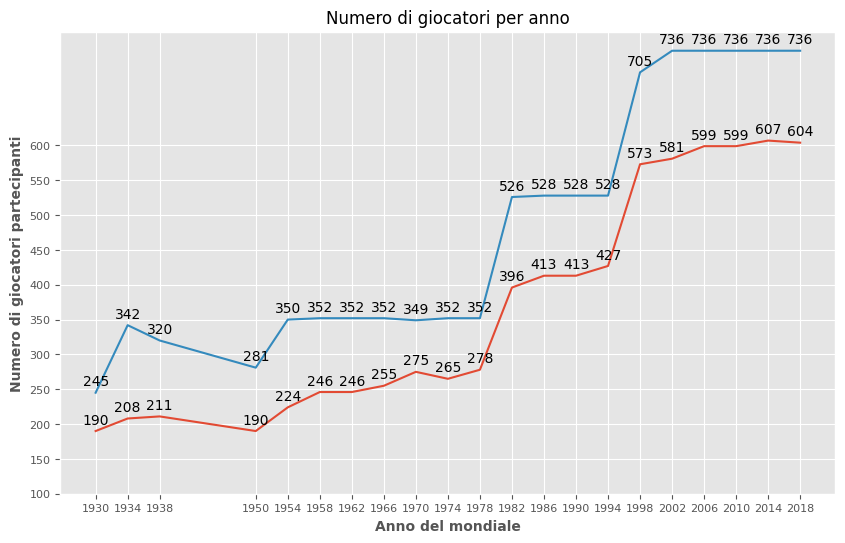

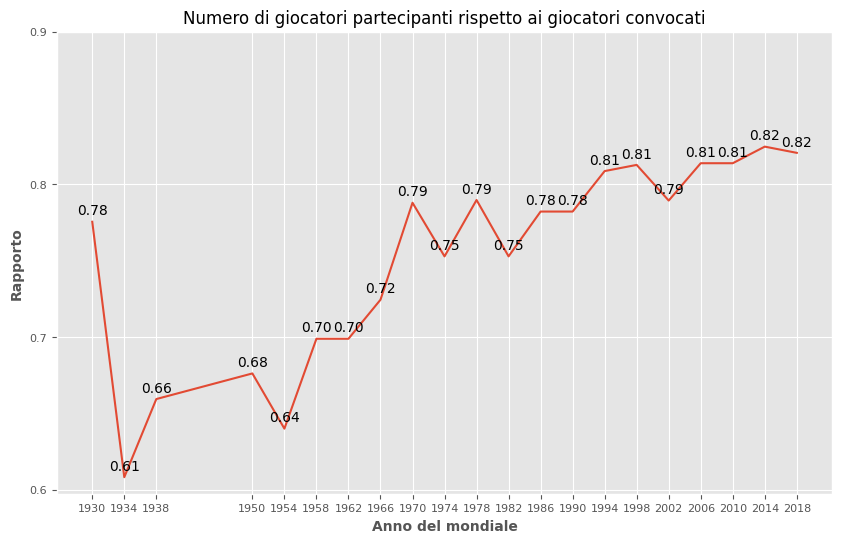

In [91]:
#total players for year

df_player_appearances = pd.read_csv(PATH_FROM_READ_ANALYSIS + "player_appearances.csv")
df_squads = pd.read_csv(PATH_FROM_READ_ANALYSIS + "squads.csv")

df_player_appearances = df_player_appearances[["tournament_id","player_id"]].drop_duplicates()
df_player_appearances['tournament_id'] = df_player_appearances['tournament_id'].str.replace('WC-','')
df_player_appearances['tournament_id'] = df_player_appearances['tournament_id'].astype(int)

df_player_for_years = df_player_appearances.groupby(["tournament_id"]).size()\
                     .reset_index(name="n_players")\
                     .rename(columns={"tournament_id":"year"})\
                     .sort_values(by="year",ascending=True)

df_squads = df_squads[["tournament_id","player_id"]].drop_duplicates()
df_squads['tournament_id'] = df_squads['tournament_id'].str.replace('WC-','')
df_squads['tournament_id'] = df_squads['tournament_id'].astype(int)

df_squads_for_years = df_squads.groupby(["tournament_id"]).size()\
                     .reset_index(name="n_players")\
                     .rename(columns={"tournament_id":"year"})\
                     .sort_values(by="year",ascending=True)


x_squad = df_squads_for_years["year"]
y_squad = df_squads_for_years["n_players"]

x = df_player_for_years["year"]
y = df_player_for_years["n_players"]

plt.figure(figsize=(10,6))
plt.plot(x,y)
for a,b in zip(x, y): 
    plt.annotate(str(b), 
                 (a,b), 
                 textcoords="offset points",
                 xytext=(0,5),
                 #fontweight='bold',
                 ha='center')
plt.plot(x_squad,y_squad)
for a,b in zip(x_squad, y_squad): 
    plt.annotate(str(b), 
                 (a,b), 
                 textcoords="offset points",
                 xytext=(0,5),
                 #fontweight='bold',
                 ha='center')


plt.title("Numero di giocatori per anno",size=12)
plt.xlabel("Anno del mondiale", size=10,fontweight='bold')
plt.ylabel("Numero di giocatori partecipanti", size=10,fontweight='bold')
plt.xticks(x, size=8)
plt.yticks([i for i in range(100,max(y),50)], size=8)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x_squad,y/y_squad)
for a,b in zip(x_squad, y/y_squad): 

    plt.annotate("{:.2f}".format(b), 
                 (a,b), 
                 textcoords="offset points",
                 xytext=(0,5),
                 #fontweight='bold',
                 ha='center')


plt.title("Numero di giocatori partecipanti rispetto ai giocatori convocati",size=12)
plt.xlabel("Anno del mondiale", size=10,fontweight='bold')
plt.ylabel("Rapporto", size=10,fontweight='bold')
plt.xticks(x, size=8)
plt.yticks([i for i in np.arange(0.6, 1, 0.1)], size=8)
plt.show()

#plt.show()



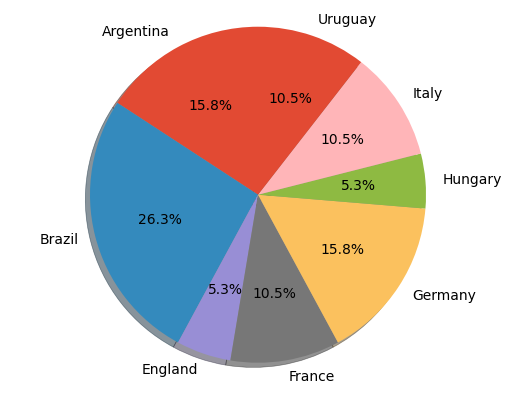

In [105]:
#Analisi cluster allenatori
manager_c_0 = pd.read_csv("clusters/clusters_managers/0.csv")
manager_c_1 = pd.read_csv("clusters/clusters_managers/1.csv")
manager_c_2 = pd.read_csv("clusters/clusters_managers/2.csv")
manager_c_3 = pd.read_csv("clusters/clusters_managers/3.csv")
manager_c_4 = pd.read_csv("clusters/clusters_managers/4.csv")
manager_c_5 = pd.read_csv("clusters/clusters_managers/5.csv")
manager_c_6 = pd.read_csv("clusters/clusters_managers/6.csv")

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = manager_c_3.groupby("country_name")["country_name"].size().reset_index(name="count")
fig1, ax1 = plt.subplots()
ax1.pie(sizes["count"], labels=sizes["country_name"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [ ]:
#NON TOCCARE - Divisione dei giocatori in base all'anno in cui hanno giocato

df_players = pd.read_csv(PATH_FROM_READ_ETL + "players.csv")
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966]

for year in years:
    df = df_players[df_players['list_tournaments'].str.contains(str(year))]
    df = df[["player_id","family_name","given_name","goal_keeper","defender","midfielder","forward"]]
    df["shirt_number"] = ""

    df.loc[df["goal_keeper"]==1, "position_name"] = "goal keeper"
    df.loc[df["goal_keeper"]==1, "position_code"] = "GK"

    df.loc[df["defender"]==1, "position_name"] = "defender"
    df.loc[df["defender"]==1, "position_code"] = "DF"

    df.loc[df["midfielder"]==1, "position_name"] = "midfielder"
    df.loc[df["midfielder"]==1, "position_code"] = "MF"
    
    df.loc[df["forward"]==1, "position_name"] = "forward"
    df.loc[df["forward"]==1, "position_code"] = "FW"

    df = df.drop(columns=["goal_keeper","defender","midfielder","forward"])

    df.to_csv("./players_by_year/players_"+str(year)+".csv",index=False)

In [6]:
#NON TOCCARE - E' servito per creare il dataset in cui bisognava inserire manualmente i players

df_matches = pd.read_csv(PATH_FROM_READ_ETL + "matches.csv")
df_tournaments = pd.read_csv(PATH_FROM_READ_ETL + "tournaments.csv")

#df_matches = df_matches[df_matches["Year"] < 1970]
df_tournaments = df_tournaments[df_tournaments["year"] < 1970]
df_tournaments = df_tournaments[["tournament_id","year"]]
df_matches = df_matches.merge(df_tournaments,on="tournament_id",how="inner")
df_matches = df_matches.drop(columns=["year"])
df_matches.to_csv("year_1930_1966.csv",index=False)
df_matches = pd.read_csv("./year_1930_1966.csv")
df_tournaments = pd.read_csv(PATH_FROM_READ_ETL + "tournaments.csv")
df_player_appearances = pd.read_csv(PATH_FROM_READ_ETL + "player_appearances.csv")

k = len(df_player_appearances)
data = []
for j in range(len(df_matches)):
    cap=0
    for i in range(0,11):
        if i==0 :cap=1
        else : cap = 0 
        k+=1
        data.append([k, 
                    df_matches.loc[j]['tournament_id'], df_matches.loc[j]['tournament_name'], df_matches.loc[j]['match_id'],
                    df_matches.loc[j]['match_name'], df_matches.loc[j]['match_date'], df_matches.loc[j]['stage_name'],
                    df_matches.loc[j]['group_name'], df_matches.loc[j]['home_team_id'], df_matches.loc[j]['home_team_name'],
                    df_matches.loc[j]['home_team_code'], 1, 0, "", "", "", "", "", "", 1, 0, cap
                    ])
    for i in range(12,23):
        if i==12 :cap=1
        else : cap = 0 
        k+=1
        data.append([k, df_matches.loc[j]['tournament_id'], df_matches.loc[j]['tournament_name'], df_matches.loc[j]['match_id'],
                    df_matches.loc[j]['match_name'], df_matches.loc[j]['match_date'], df_matches.loc[j]['stage_name'],
                    df_matches.loc[j]['group_name'], df_matches.loc[j]['away_team_id'], df_matches.loc[j]['away_team_name'],
                    df_matches.loc[j]['away_team_code'], 0, 1, "", "", "", "", "", "", 1, 0, cap
                    ])

df_test = pd.DataFrame(data, columns=df_player_appearances.columns.to_list())
df_test.to_csv("test.csv",index=False)